### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import src.visualization as vis
import src.geometry as geo
import src.animations as ani

### Data

In [2]:
polygons = [
    [(0.6450541834677419, 0.3713149126838235), (0.833562247983871, 0.570150696997549), (0.5363848286290323, 0.6712536381740195), (0.3390057963709677, 0.9341212852328431), (0.10170740927419353, 0.7453957950367647), (0.2369896673387097, 0.4353467754289216), (0.07952998991935484, 0.1623688342524509), (0.2857799899193548, -0.029726753982843246), (0.8601751512096775, 0.22977079503676462)],
    [(0.6384009576612903, 0.839758540134804), (0.4565461189516129, 0.9273810891544119), (0.24142515120967745, 0.8801997166053921), (0.0884009576612903, 0.5802609911151961), (0.09505418346774192, 0.24999138327205878), (0.20594128024193548, 0.07474628523284305), (0.47428805443548383, 0.01745461856617636), (0.6894090221774194, 0.09496687346813715), (0.7625945060483871, 0.27021197150735293), (0.7759009576612904, 0.5566703048406862), (0.7027154737903226, 0.7588761871936274)],
    [(0.49202998991935487, 0.07137618719362737), (0.591828377016129, 0.3746850107230392), (0.8180380544354838, 0.5162291283700979), (0.591828377016129, 0.6577732460171568), (0.4853767641129032, 0.9476016773897058), (0.3744896673387097, 0.6678835401348038), (0.18376386088709679, 0.5398198146446078), (0.3789251512096774, 0.3881654028799019)],
    [(0.4609816028225806, 0.9238530177696078), (0.2569493447580645, 0.7519780177696078), (0.4454574092741935, 0.5868432138480393), (0.27025579637096775, 0.49922066482843136), (0.6472719254032259, 0.08806870404411754)],
    [(0.4676348286290323, 0.8463407628676471), (0.3057396673387097, 0.07458831188725479), (0.6051348286290322, 0.4217084099264706), (0.49202998991935487, 0.5699927236519609), (0.6117880544354839, 0.6980564491421568)]
]

### Example

#### Classification

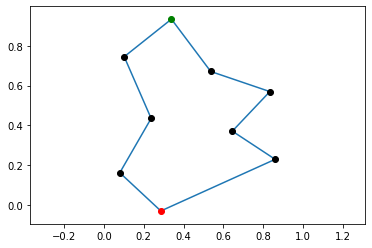

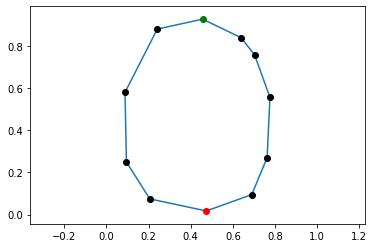

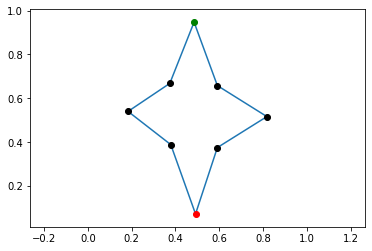

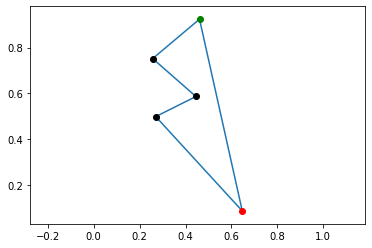

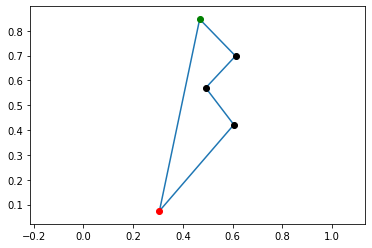

In [3]:
for poly in polygons:
    classification = geo.classify_poly(poly)
    vis.plot_chain(poly, closed=True)
    vis.plot_classification(poly, classification)
    plt.show()

#### Check for y-monotonic

In [4]:
for poly in polygons:
    print(geo.is_y_monotonic(poly))

True
True
True
True
True


#### Splitting into two chains

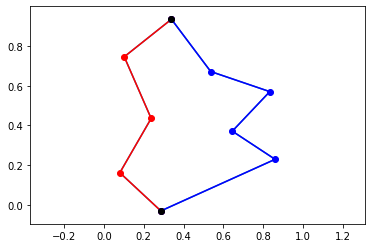

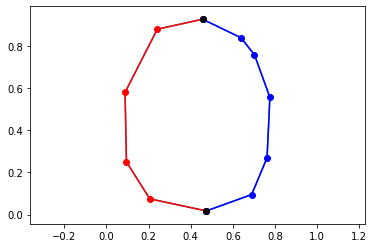

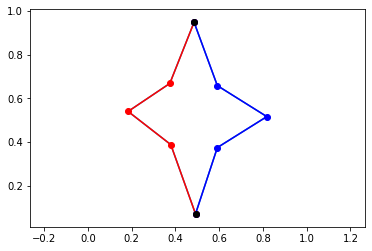

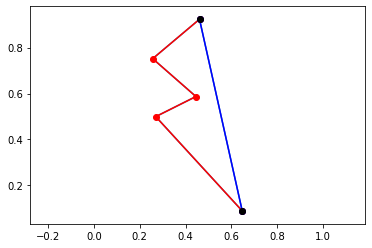

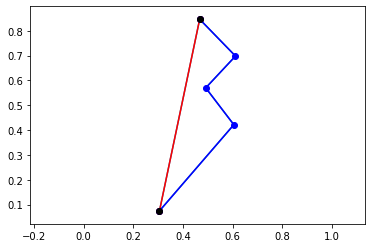

In [5]:
for poly in polygons:
    left, right = geo.poly_to_two_chains(poly)
    vis.plot_chain(poly, closed=True)
    vis.plot_chain(left, color='r')
    vis.plot_points(left, color='r')
    vis.plot_chain(right, color='b')
    vis.plot_points(right, color='b')
    vis.plot_points([left[0], right[0]], color='black')
    plt.show()

#### Triangulation

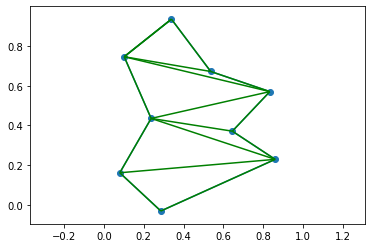

In [6]:
ani.TriangulationAnimation(polygons[0], ani.triangulate_monotonic_generator(polygons[0])).animation

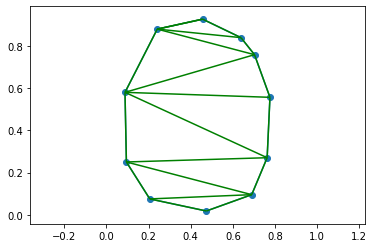

In [7]:
ani.TriangulationAnimation(polygons[1], ani.triangulate_monotonic_generator(polygons[1])).animation

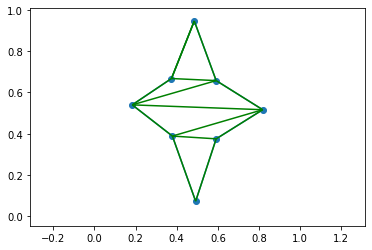

In [8]:
ani.TriangulationAnimation(polygons[2], ani.triangulate_monotonic_generator(polygons[2])).animation

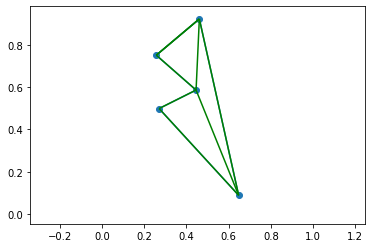

In [9]:
ani.TriangulationAnimation(polygons[3], ani.triangulate_monotonic_generator(polygons[3])).animation

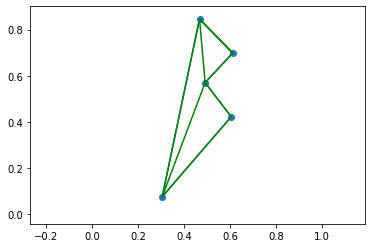

In [10]:
ani.TriangulationAnimation(polygons[4], ani.triangulate_monotonic_generator(polygons[4])).animation

### Interactive version

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [12]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

<IPython.core.display.Javascript object>


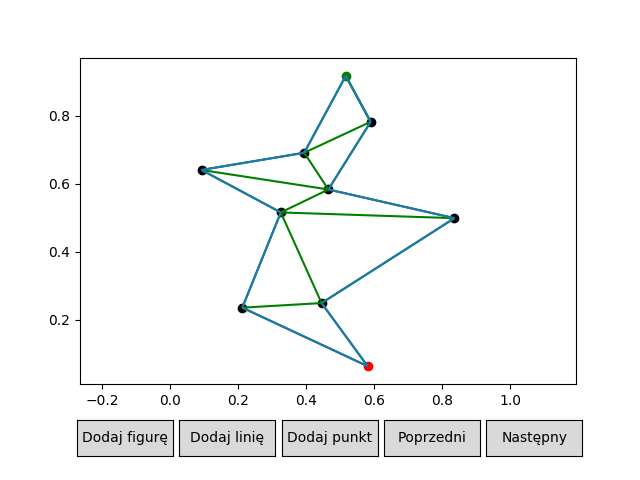

In [13]:
%matplotlib notebook
plot1 = Plot()
plot1.draw()

In [14]:
poly = geo.to_polygon(plot1.get_added_elements().lines[0].lines)
vis.plot_classification(poly, geo.classify_poly(poly))

if geo.is_y_monotonic(poly):
    vis.plot_segments(geo.triangulate_monotonic(poly), colors='g')